In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
import pickle


import warnings
warnings.filterwarnings(action='ignore') 

# 사이킷런
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 회귀
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
pd.set_option('display.max_row', 5000)
pd.set_option('display.max_columns', 100)

from matplotlib import font_manager, rc
import matplotlib
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()

rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

In [4]:
dir='C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\19-20_방울토마토_아리울_박문신(재배기간_2019.07.23~2020.06.30)/'
sang_data1 = pd.read_excel(dir+'19-20작기_방울토마토_아리울_박문신_생육1.xlsx')
sang_data2 = pd.read_excel(dir+'19-20작기_방울토마토_아리울_박문신_생육2.xlsx')
env_data = pd.read_excel(dir+'19-20작기_방울토마토_아리울_박문신_환경(2019.07.23~2020.06.30).xlsx')
yang_data = pd.read_excel(dir+'19-20작기_방울토마토_아리울_박문신_양액(2019.07.23~2020.06.30).xlsx')

In [5]:
env_data=env_data[['date', '내부온도', '내부습도','CO2','누적일사량']]

# 생육에 주차 추가

In [6]:
# 주차 추가
def add_weeknum(sang_df):
    sang_df['diff']=sang_df['WeekNum'].shift(1)
    sang_df['diff2']=sang_df['WeekNum']-sang_df['diff']
    
    num=-1
    test_week=[]
    for i in range(len(sang_df)):
        if sang_df['diff2'].loc[i]!=0:
            num+=1
            test_week.append(num)
        else:
            test_week.append(num)
    del sang_df['diff']
    del sang_df['diff2']
    return test_week

In [7]:
sang_data1['주차']=add_weeknum(sang_data1)
sang_data2['주차']=add_weeknum(sang_data2)

In [8]:
sang_data1=sang_data1[['Date','Sample','주차','생장길이']]
sang_data2=sang_data2[['Date','Sample','주차','생장길이']]

# 생육 이상치 제거 (선택에 따라 이 과정 안하고 넘어가도 됨) 

In [9]:
q1 = sang_data1['생장길이'].quantile(0.25)
q3 = sang_data1['생장길이'].quantile(0.75)

iqt = 1.5 * (q3 - q1)

# 이상치 제거

sang_data_delout1=sang_data1[(sang_data1['생장길이'] < (q3 + iqt)) & (sang_data1['생장길이'] > (q1 - iqt))]




In [10]:
q1 = sang_data2['생장길이'].quantile(0.25)
q3 = sang_data2['생장길이'].quantile(0.75)

iqt = 1.5 * (q3 - q1)

# 이상치 제거

sang_data_delout2=sang_data2[(sang_data2['생장길이'] < (q3 + iqt)) & (sang_data2['생장길이'] > (q1 - iqt))]

# 환경 12시간 단위로 끊기

In [11]:
# 12시간 짤라서 Date 추가
def env_add_Date(env_df,생육조사기간):
    df=pd.DataFrame()
    for i in range(len(생육조사기간)-1):
        start_i = 생육조사기간[i]+timedelta(hours=12)
        end_i = 생육조사기간[i+1]+timedelta(hours=12)

        df2 = env_df[(env_df['date']>=start_i) & (env_df['date']<end_i)]
        df2['Date']=생육조사기간[i+1]


        df=pd.concat([df,df2])
    return df

In [14]:
생육조사기간=sorted(list(set(list(sang_data1['Date']))))
env_data1=env_add_Date(env_data,생육조사기간)

In [15]:
생육조사기간=sorted(list(set(list(sang_data2['Date']))))
env_data2=env_add_Date(env_data,생육조사기간)

# 환경날짜와 측정 날짜의 차이를 구함

In [16]:
env_data1['n_date']=env_data1['date'].apply(lambda x : x.strftime('%Y-%m-%d'))
env_data2['n_date']=env_data2['date'].apply(lambda x : x.strftime('%Y-%m-%d'))

In [17]:
def n_date(d):
    myDatetimeStr = d
    myDatetime = datetime.strptime(myDatetimeStr, '%Y-%m-%d')
    return myDatetime

In [18]:
env_data1['n_date']=env_data1['n_date'].apply(n_date)
env_data2['n_date']=env_data2['n_date'].apply(n_date)

In [19]:
env_data1['diff']=env_data1['Date']-env_data1['n_date']
env_data2['diff']=env_data2['Date']-env_data2['n_date']

In [26]:
env_data1.head(10)

,date,내부온도,내부습도,CO2,Date,n_date,diff,일사량
4464,2019-08-07 12:00:00,37.9,54,295,2019-08-13,2019-08-07,6 days,0.0
4465,2019-08-07 12:05:00,38.8,54,289,2019-08-13,2019-08-07,6 days,20.2
4466,2019-08-07 12:10:00,39.0,54,287,2019-08-13,2019-08-07,6 days,20.6
4467,2019-08-07 12:15:00,39.2,53,286,2019-08-13,2019-08-07,6 days,20.8
4468,2019-08-07 12:20:00,39.6,52,285,2019-08-13,2019-08-07,6 days,20.5
4469,2019-08-07 12:25:00,39.5,51,281,2019-08-13,2019-08-07,6 days,20.8
4470,2019-08-07 12:30:00,39.8,50,281,2019-08-13,2019-08-07,6 days,22.2
4471,2019-08-07 12:35:00,39.5,51,280,2019-08-13,2019-08-07,6 days,14.9
4472,2019-08-07 12:40:00,39.1,53,285,2019-08-13,2019-08-07,6 days,12.1
4473,2019-08-07 12:45:00,38.5,55,285,2019-08-13,2019-08-07,6 days,11.6


In [27]:
env_data2.head(10)

,date,내부온도,내부습도,CO2,Date,n_date,diff,일사량
44208,2019-12-23 12:00:00,21.3,76,458,2019-12-30,2019-12-23,7 days,0.0
44209,2019-12-23 12:05:00,22.1,75,452,2019-12-30,2019-12-23,7 days,13.4
44210,2019-12-23 12:10:00,22.6,72,447,2019-12-30,2019-12-23,7 days,14.7
44211,2019-12-23 12:15:00,22.5,69,440,2019-12-30,2019-12-23,7 days,14.5
44212,2019-12-23 12:20:00,21.9,68,441,2019-12-30,2019-12-23,7 days,9.6
44213,2019-12-23 12:25:00,20.9,69,441,2019-12-30,2019-12-23,7 days,6.3
44214,2019-12-23 12:30:00,22.0,70,434,2019-12-30,2019-12-23,7 days,11.4
44215,2019-12-23 12:35:00,22.5,72,436,2019-12-30,2019-12-23,7 days,6.9
44216,2019-12-23 12:40:00,21.4,71,440,2019-12-30,2019-12-23,7 days,7.8
44217,2019-12-23 12:45:00,20.7,68,445,2019-12-30,2019-12-23,7 days,12.0


# 일사량 해결

In [22]:
def cumsum_to_value(df):
    #누적일사량 해결
    df['lag_누적일사량']=df['누적일사량'].shift(1)
    df['일사량2']=df['누적일사량']-df['lag_누적일사량']

    #음수를 0으로 치환 NA를 0으로 치환
    df['일사량2_치환']=df['일사량2'].apply(lambda x : 0 if x<0 else x)
    df['일사량']=df['일사량2_치환'].fillna(0)

    del df['lag_누적일사량']
    del df['일사량2']
    del df['일사량2_치환']
    return df

In [23]:
base_col=['date','Date']
cumsum_list=['누적일사량']
cumsum_col=base_col+cumsum_list

In [24]:
cumsum_df1=cumsum_to_value(env_data1[cumsum_col])
env_data1['일사량']=cumsum_df1['일사량']
del env_data1['누적일사량']

In [25]:
cumsum_df2=cumsum_to_value(env_data2[cumsum_col])
env_data2['일사량']=cumsum_df2['일사량']
del env_data2['누적일사량']

# 환경 주차 생성

In [28]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,env_data):
    dic=dict(zip(sang_data['Date'],sang_data['주차']))
    result=env_data.replace({"Date":dic})["Date"]
    return result

In [29]:
env_data1['주차']=match_test_weeknum(sang_data1,env_data1)
env_data2['주차']=match_test_weeknum(sang_data2,env_data2)

In [39]:
env_data2

,date,내부온도,내부습도,CO2,Date,n_date,diff,일사량,주차
44208,2019-12-23 12:00:00,21.3,76,458,2019-12-30,2019-12-23,7 days,0.0,1
44209,2019-12-23 12:05:00,22.1,75,452,2019-12-30,2019-12-23,7 days,13.4,1
44210,2019-12-23 12:10:00,22.6,72,447,2019-12-30,2019-12-23,7 days,14.7,1
44211,2019-12-23 12:15:00,22.5,69,440,2019-12-30,2019-12-23,7 days,14.5,1
44212,2019-12-23 12:20:00,21.9,68,441,2019-12-30,2019-12-23,7 days,9.6,1
...,...,...,...,...,...,...,...,...,...
98635,2020-06-29 11:35:00,27.9,76,372,2020-06-29,2020-06-29,0 days,7.8,27
98636,2020-06-29 11:40:00,27.9,76,367,2020-06-29,2020-06-29,0 days,8.2,27
98637,2020-06-29 11:45:00,28.2,76,362,2020-06-29,2020-06-29,0 days,8.9,27
98638,2020-06-29 11:50:00,28.6,75,363,2020-06-29,2020-06-29,0 days,10.3,27


# 환경 pivot

In [30]:
def remove_outlier_pivot(df,col,aggfunc):
    cut_df=pd.DataFrame()
    for i in range(len(df['주차'].unique())):
        k=df[df['주차']==i+1]
        
        
        q1 = k[col].quantile(0.25)
        q3 = k[col].quantile(0.75)

        iqt = 1.5 * (q3 - q1)

        # 이상치 제거

        k=k[(k[col] < (q3 + iqt)) & (k[col] > (q1 - iqt))]
        
        cut_df=pd.concat([cut_df,k])

    result = cut_df.pivot_table(index=['n_date'],
                               values=col,
                               aggfunc=aggfunc).reset_index(drop=False)

    return result

In [31]:
# 평균으로 집계할 변수와, 합으로 집계할 변수 설정하기
base_col=['date','Date','주차','diff']
avg_list=['내부온도','내부습도','CO2']
sum_list=['일사량']
cols=avg_list+sum_list
aggfunc=['mean']*len(avg_list)+['sum']*len(sum_list)

In [40]:
i=0
for col,agg in zip(cols,aggfunc):
    df=env_data1[[col,'n_date','주차']]

    # 이상치 제거, 피봇
    my_pivot = remove_outlier_pivot(df,col,agg)
    
    if i==0:
        result1 = my_pivot
        i+=1
        continue

    result1 = pd.merge(result1,my_pivot,how='inner',on='n_date')

In [41]:
i=0
for col,agg in zip(cols,aggfunc):
    df=env_data2[[col,'n_date','주차']]

    # 이상치 제거, 피봇
    my_pivot = remove_outlier_pivot(df,col,agg)
    
    if i==0:
        result2 = my_pivot
        i+=1
        continue

    result2 = pd.merge(result2,my_pivot,how='inner',on='n_date')

In [42]:
result1.head(5)

,n_date,내부온도,내부습도,CO2,일사량
0,2019-08-07,34.656944,67.958333,335.590278,1179.7
1,2019-08-08,31.973958,78.173611,392.545139,1517.6
2,2019-08-09,32.909028,72.909722,364.576389,1871.4
3,2019-08-10,33.057292,68.923611,373.347222,1953.0
4,2019-08-11,31.480556,68.184028,359.083333,1534.5


In [43]:
result2.head(5)

,n_date,내부온도,내부습도,CO2,일사량
0,2019-12-23,16.117925,76.083333,479.888889,82.1
1,2019-12-24,15.818140,76.847107,559.083333,70.3
2,2019-12-25,16.024454,79.836735,579.312500,110.0
3,2019-12-26,16.297917,85.170139,675.013889,167.5
4,2019-12-27,15.793088,79.641434,578.597222,66.3


# 지연변수 생성(하루)

In [139]:
p=result1
lag_result1=result1
for i in range(10):
    raw_col=p.columns[1:]
    later_df=p.iloc[:,1:].shift(periods=i+1)
    later_col=['_'+str(i+1)+'일전_'+j for j in list(raw_col)]
    later_df.columns=later_col

    lag_result1=pd.concat([lag_result1,later_df],axis=1)

In [140]:
p=result2
lag_result2=result2
for i in range(10):
    raw_col=p.columns[1:]
    later_df=p.iloc[:,1:].shift(periods=i+1)
    later_col=['_'+str(i+1)+'일전_'+j for j in list(raw_col)]
    later_df.columns=later_col

    lag_result2=pd.concat([lag_result2,later_df],axis=1)

In [141]:
lag_result1.head(5)

,n_date,내부온도,내부습도,CO2,일사량,_1일전_내부온도,_1일전_내부습도,_1일전_CO2,_1일전_일사량,_2일전_내부온도,_2일전_내부습도,_2일전_CO2,_2일전_일사량,_3일전_내부온도,_3일전_내부습도,_3일전_CO2,_3일전_일사량,_4일전_내부온도,_4일전_내부습도,_4일전_CO2,_4일전_일사량,_5일전_내부온도,_5일전_내부습도,_5일전_CO2,_5일전_일사량,_6일전_내부온도,_6일전_내부습도,_6일전_CO2,_6일전_일사량,_7일전_내부온도,_7일전_내부습도,_7일전_CO2,_7일전_일사량,_8일전_내부온도,_8일전_내부습도,_8일전_CO2,_8일전_일사량,_9일전_내부온도,_9일전_내부습도,_9일전_CO2,_9일전_일사량,_10일전_내부온도,_10일전_내부습도,_10일전_CO2,_10일전_일사량
0,2019-08-07,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-08-08,31.973958,78.173611,392.545139,1517.6,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-08-09,32.909028,72.909722,364.576389,1871.4,31.973958,78.173611,392.545139,1517.6,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-08-10,33.057292,68.923611,373.347222,1953.0,32.909028,72.909722,364.576389,1871.4,31.973958,78.173611,392.545139,1517.6,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-08-11,31.480556,68.184028,359.083333,1534.5,33.057292,68.923611,373.347222,1953.0,32.909028,72.909722,364.576389,1871.4,31.973958,78.173611,392.545139,1517.6,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
lag_result2.head(5)

,n_date,내부온도,내부습도,CO2,일사량,_1일전_내부온도,_1일전_내부습도,_1일전_CO2,_1일전_일사량,_2일전_내부온도,_2일전_내부습도,_2일전_CO2,_2일전_일사량,_3일전_내부온도,_3일전_내부습도,_3일전_CO2,_3일전_일사량,_4일전_내부온도,_4일전_내부습도,_4일전_CO2,_4일전_일사량,_5일전_내부온도,_5일전_내부습도,_5일전_CO2,_5일전_일사량,_6일전_내부온도,_6일전_내부습도,_6일전_CO2,_6일전_일사량,_7일전_내부온도,_7일전_내부습도,_7일전_CO2,_7일전_일사량,_8일전_내부온도,_8일전_내부습도,_8일전_CO2,_8일전_일사량,_9일전_내부온도,_9일전_내부습도,_9일전_CO2,_9일전_일사량,_10일전_내부온도,_10일전_내부습도,_10일전_CO2,_10일전_일사량,_11일전_내부온도,_11일전_내부습도,_11일전_CO2,_11일전_일사량,_12일전_내부온도,_12일전_내부습도,_12일전_CO2,_12일전_일사량,_13일전_내부온도,_13일전_내부습도,_13일전_CO2,_13일전_일사량,_14일전_내부온도,_14일전_내부습도,_14일전_CO2,_14일전_일사량,_15일전_내부온도,_15일전_내부습도,_15일전_CO2,_15일전_일사량,_16일전_내부온도,_16일전_내부습도,_16일전_CO2,_16일전_일사량,_17일전_내부온도,_17일전_내부습도,_17일전_CO2,_17일전_일사량,_18일전_내부온도,_18일전_내부습도,_18일전_CO2,_18일전_일사량,_19일전_내부온도,_19일전_내부습도,_19일전_CO2,_19일전_일사량,_20일전_내부온도,_20일전_내부습도,_20일전_CO2,_20일전_일사량
0,2019-12-23,16.117925,76.083333,479.888889,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-12-24,15.818140,76.847107,559.083333,70.3,16.117925,76.083333,479.888889,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-25,16.024454,79.836735,579.312500,110.0,15.818140,76.847107,559.083333,70.3,16.117925,76.083333,479.888889,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-12-26,16.297917,85.170139,675.013889,167.5,16.024454,79.836735,579.312500,110.0,15.818140,76.847107,559.083333,70.3,16.117925,76.083333,479.888889,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-27,15.793088,79.641434,578.597222,66.3,16.297917,85.170139,675.013889,167.5,16.024454,79.836735,579.312500,110.0,15.818140,76.847107,559.083333,70.3,16.117925,76.083333,479.888889,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 주차 추가

In [142]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,env_data):
    dic=dict(zip(sang_data['Date'],sang_data['주차']))
    result=env_data.replace({"n_date":dic})["n_date"]
    return result

In [143]:
lag_result1['주차']=match_test_weeknum(sang_data1,lag_result1)
lag_result2['주차']=match_test_weeknum(sang_data2,lag_result2)

In [144]:
for i in range(len(lag_result1)):
    if type(lag_result1['주차'].iloc[i])==int:
        k=lag_result1['주차'].iloc[i]
    else:
        lag_result1['주차'].iloc[i]=k
        
for i in range(len(lag_result2)):
    if type(lag_result2['주차'].iloc[i])==int:
        k=lag_result2['주차'].iloc[i]
    else:
        lag_result2['주차'].iloc[i]=k

In [145]:
lag_result1=lag_result1.iloc[:,1:]
lag_result2=lag_result2.iloc[:,1:]

In [51]:
lag_result1.head(50)

,내부온도,내부습도,CO2,일사량,_20일전_내부온도,_20일전_내부습도,_20일전_CO2,_20일전_일사량,주차
0,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,0
1,31.973958,78.173611,392.545139,1517.6,NaN,NaN,NaN,NaN,0
2,32.909028,72.909722,364.576389,1871.4,NaN,NaN,NaN,NaN,0
3,33.057292,68.923611,373.347222,1953.0,NaN,NaN,NaN,NaN,0
4,31.480556,68.184028,359.083333,1534.5,NaN,NaN,NaN,NaN,0
5,30.779861,81.968750,345.378472,939.2,NaN,NaN,NaN,NaN,0
6,32.898264,73.211806,342.809028,1903.4,NaN,NaN,NaN,NaN,1
7,32.530208,76.017361,370.777778,1854.5,NaN,NaN,NaN,NaN,1
8,29.365972,79.993056,347.583333,1078.9,NaN,NaN,NaN,NaN,1
9,30.076736,79.302083,348.114583,1558.2,NaN,NaN,NaN,NaN,1


# 양액 데이터

In [335]:
yang_data = yang_data[['date','Irrigation (dripper) [ml]','Number of irrigation starts based on radiation sum','Total number of irrigation starts']]

In [336]:
yang_data['n_date']=yang_data['date'].apply(lambda x : x.strftime('%Y-%m-%d'))

In [337]:
def n_date(d):
    myDatetimeStr = d
    myDatetime = datetime.strptime(myDatetimeStr, '%Y-%m-%d')
    return myDatetime

In [338]:
yang_data['date']=yang_data['n_date'].apply(n_date)
del yang_data['n_date']

In [339]:
g_yang_data=yang_data.groupby(['date'])['Number of irrigation starts based on radiation sum','Total number of irrigation starts'].agg('max').reset_index()
g_yang_data.head(5)

,date,Number of irrigation starts based on radiation sum,Total number of irrigation starts
0,2019-07-23,43,71
1,2019-07-24,16,19
2,2019-07-25,16,19
3,2019-07-26,9,12
4,2019-07-27,5,12


In [340]:
def biger(df):
    if df['Number of irrigation starts based on radiation sum']>=df['Total number of irrigation starts']:
        return df['Number of irrigation starts based on radiation sum']
    else:
        return df['Total number of irrigation starts']
g_yang_data['big']=g_yang_data.apply(biger,axis=1)

In [341]:
g_yang_data['tot_yang']=g_yang_data['big']*70.9

In [342]:
del g_yang_data['Number of irrigation starts based on radiation sum']
del g_yang_data['Total number of irrigation starts']
del g_yang_data['big']

In [343]:
g_yang_data.head(5)

,date,tot_yang
0,2019-07-23,5033.9
1,2019-07-24,1347.1
2,2019-07-25,1347.1
3,2019-07-26,850.8
4,2019-07-27,850.8


In [344]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,g_yang_data):
    dic=dict(zip(sang_data['Date'],sang_data['주차']))
    result=g_yang_data.replace({"date":dic})["date"]
    return result

In [345]:
# 양액 데이터에 주차 컬럼 추가
g_yang_data['주차1']=match_test_weeknum(sang_data1,g_yang_data)
g_yang_data['주차2']=match_test_weeknum(sang_data2,g_yang_data)

In [346]:
d1=sang_data1['Date'].max().strftime('%Y-%m-%d')
d2=sang_data2['Date'].max().strftime('%Y-%m-%d')

In [347]:
start_idx1=g_yang_data[g_yang_data['주차1']==0].index
start_idx2=g_yang_data[g_yang_data['주차2']==0].index

In [348]:
end_idx1=g_yang_data[g_yang_data['date']==datetime.strptime(d1,'%Y-%m-%d')].index
end_idx2=g_yang_data[g_yang_data['date']==datetime.strptime(d2,'%Y-%m-%d')].index

In [349]:
yang_data1=g_yang_data.iloc[start_idx1[0]:end_idx1[0],:]
yang_data2=g_yang_data.iloc[start_idx2[0]:end_idx2[0],:]


In [350]:
del yang_data1['주차2']
del yang_data2['주차1']

In [351]:
yang_data1=yang_data1[['date', '주차1', 'tot_yang']]
yang_data2=yang_data2[['date', '주차2', 'tot_yang']]

In [353]:
yang_data1.head(5)

,date,주차1,tot_yang
15,2019-08-07,0,212.7
16,2019-08-08,2019-08-08 00:00:00,212.7
17,2019-08-09,2019-08-09 00:00:00,354.5
18,2019-08-10,2019-08-10 00:00:00,425.4
19,2019-08-11,2019-08-11 00:00:00,425.4


In [354]:
yang_data2.head(5)

,date,주차2,tot_yang
153,2019-12-23,0,283.6
154,2019-12-24,2019-12-24 00:00:00,354.5
155,2019-12-25,2019-12-25 00:00:00,425.4
156,2019-12-26,2019-12-26 00:00:00,70.9
157,2019-12-27,2019-12-27 00:00:00,354.5


# 지연

In [355]:
p=yang_data1
yang_lag_result1=yang_data1
for i in range(10):
    raw_col=p.columns[2:]
    later_df=p.iloc[:,2:].shift(periods=i+1)
    later_col=['_'+str(i+1)+'일전_'+j for j in list(raw_col)]
    later_df.columns=later_col

    yang_lag_result1=pd.concat([yang_lag_result1,later_df],axis=1)

In [356]:
p=yang_data2
yang_lag_result2=yang_data2
for i in range(10):
    raw_col=p.columns[2:]
    later_df=p.iloc[:,2:].shift(periods=i+1)
    later_col=['_'+str(i+1)+'일전_'+j for j in list(raw_col)]
    later_df.columns=later_col

    yang_lag_result2=pd.concat([yang_lag_result2,later_df],axis=1)

In [360]:
yang_lag_result1.head(15)

,date,주차1,tot_yang,_1일전_tot_yang,_2일전_tot_yang,_3일전_tot_yang,_4일전_tot_yang,_5일전_tot_yang,_6일전_tot_yang,_7일전_tot_yang,_8일전_tot_yang,_9일전_tot_yang,_10일전_tot_yang
15,2019-08-07,0,212.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,2019-08-08,2019-08-08 00:00:00,212.7,212.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2019-08-09,2019-08-09 00:00:00,354.5,212.7,212.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2019-08-10,2019-08-10 00:00:00,425.4,354.5,212.7,212.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,2019-08-11,2019-08-11 00:00:00,425.4,425.4,354.5,212.7,212.7,NaN,NaN,NaN,NaN,NaN,NaN
20,2019-08-12,2019-08-12 00:00:00,425.4,425.4,425.4,354.5,212.7,212.7,NaN,NaN,NaN,NaN,NaN
21,2019-08-13,1,425.4,425.4,425.4,425.4,354.5,212.7,212.7,NaN,NaN,NaN,NaN
22,2019-08-14,2019-08-14 00:00:00,425.4,425.4,425.4,425.4,425.4,354.5,212.7,212.7,NaN,NaN,NaN
23,2019-08-15,2019-08-15 00:00:00,283.6,425.4,425.4,425.4,425.4,425.4,354.5,212.7,212.7,NaN,NaN
24,2019-08-16,2019-08-16 00:00:00,709.0,283.6,425.4,425.4,425.4,425.4,425.4,354.5,212.7,212.7,NaN


In [359]:
yang_lag_result2.head(15)

,date,주차2,tot_yang,_1일전_tot_yang,_2일전_tot_yang,_3일전_tot_yang,_4일전_tot_yang,_5일전_tot_yang,_6일전_tot_yang,_7일전_tot_yang,_8일전_tot_yang,_9일전_tot_yang,_10일전_tot_yang
153,2019-12-23,0,283.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,2019-12-24,2019-12-24 00:00:00,354.5,283.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,2019-12-25,2019-12-25 00:00:00,425.4,354.5,283.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,2019-12-26,2019-12-26 00:00:00,70.9,425.4,354.5,283.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,2019-12-27,2019-12-27 00:00:00,354.5,70.9,425.4,354.5,283.6,NaN,NaN,NaN,NaN,NaN,NaN
158,2019-12-28,2019-12-28 00:00:00,354.5,354.5,70.9,425.4,354.5,283.6,NaN,NaN,NaN,NaN,NaN
159,2019-12-29,2019-12-29 00:00:00,354.5,354.5,354.5,70.9,425.4,354.5,283.6,NaN,NaN,NaN,NaN
160,2019-12-30,1,141.8,354.5,354.5,354.5,70.9,425.4,354.5,283.6,NaN,NaN,NaN
161,2019-12-31,2019-12-31 00:00:00,425.4,141.8,354.5,354.5,354.5,70.9,425.4,354.5,283.6,NaN,NaN
162,2020-01-01,2020-01-01 00:00:00,212.7,425.4,141.8,354.5,354.5,354.5,70.9,425.4,354.5,283.6,NaN


# 주차 추가

In [395]:
for i in range(len(yang_lag_result1)):
    if type(yang_lag_result1['주차1'].iloc[i])==int:
        k=yang_lag_result1['주차1'].iloc[i]
    else:
        yang_lag_result1['주차1'].iloc[i]=k
yang_lag_result1=yang_lag_result1.reset_index(drop=True)

In [396]:
for i in range(len(yang_lag_result2)):
    if type(yang_lag_result2['주차2'].iloc[i])==int:
        k=yang_lag_result2['주차2'].iloc[i]
    else:
        yang_lag_result2['주차2'].iloc[i]=k
yang_lag_result2=yang_lag_result2.reset_index(drop=True)

In [397]:
con_yang_env1=pd.concat([lag_result1,yang_lag_result1],axis=1)
del con_yang_env1['date']
del con_yang_env1['주차1']
con_yang_env2=pd.concat([lag_result2,yang_lag_result2],axis=1)
del con_yang_env2['date']
del con_yang_env2['주차2']

In [398]:
con_yang_env1.head(5)

,내부온도,내부습도,CO2,일사량,_1일전_내부온도,_1일전_내부습도,_1일전_CO2,_1일전_일사량,_2일전_내부온도,_2일전_내부습도,_2일전_CO2,_2일전_일사량,_3일전_내부온도,_3일전_내부습도,_3일전_CO2,_3일전_일사량,_4일전_내부온도,_4일전_내부습도,_4일전_CO2,_4일전_일사량,_5일전_내부온도,_5일전_내부습도,_5일전_CO2,_5일전_일사량,_6일전_내부온도,_6일전_내부습도,_6일전_CO2,_6일전_일사량,_7일전_내부온도,_7일전_내부습도,_7일전_CO2,_7일전_일사량,_8일전_내부온도,_8일전_내부습도,_8일전_CO2,_8일전_일사량,_9일전_내부온도,_9일전_내부습도,_9일전_CO2,_9일전_일사량,_10일전_내부온도,_10일전_내부습도,_10일전_CO2,_10일전_일사량,주차,tot_yang,_1일전_tot_yang,_2일전_tot_yang,_3일전_tot_yang,_4일전_tot_yang,_5일전_tot_yang,_6일전_tot_yang,_7일전_tot_yang,_8일전_tot_yang,_9일전_tot_yang,_10일전_tot_yang
0,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,212.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31.973958,78.173611,392.545139,1517.6,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,212.7,212.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32.909028,72.909722,364.576389,1871.4,31.973958,78.173611,392.545139,1517.6,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,354.5,212.7,212.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33.057292,68.923611,373.347222,1953.0,32.909028,72.909722,364.576389,1871.4,31.973958,78.173611,392.545139,1517.6,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,425.4,354.5,212.7,212.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31.480556,68.184028,359.083333,1534.5,33.057292,68.923611,373.347222,1953.0,32.909028,72.909722,364.576389,1871.4,31.973958,78.173611,392.545139,1517.6,34.656944,67.958333,335.590278,1179.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,425.4,425.4,354.5,212.7,212.7,NaN,NaN,NaN,NaN,NaN,NaN


In [399]:
con_yang_env2.head(5)

,내부온도,내부습도,CO2,일사량,_1일전_내부온도,_1일전_내부습도,_1일전_CO2,_1일전_일사량,_2일전_내부온도,_2일전_내부습도,_2일전_CO2,_2일전_일사량,_3일전_내부온도,_3일전_내부습도,_3일전_CO2,_3일전_일사량,_4일전_내부온도,_4일전_내부습도,_4일전_CO2,_4일전_일사량,_5일전_내부온도,_5일전_내부습도,_5일전_CO2,_5일전_일사량,_6일전_내부온도,_6일전_내부습도,_6일전_CO2,_6일전_일사량,_7일전_내부온도,_7일전_내부습도,_7일전_CO2,_7일전_일사량,_8일전_내부온도,_8일전_내부습도,_8일전_CO2,_8일전_일사량,_9일전_내부온도,_9일전_내부습도,_9일전_CO2,_9일전_일사량,_10일전_내부온도,_10일전_내부습도,_10일전_CO2,_10일전_일사량,주차,tot_yang,_1일전_tot_yang,_2일전_tot_yang,_3일전_tot_yang,_4일전_tot_yang,_5일전_tot_yang,_6일전_tot_yang,_7일전_tot_yang,_8일전_tot_yang,_9일전_tot_yang,_10일전_tot_yang
0,16.117925,76.083333,479.888889,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,283.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15.818140,76.847107,559.083333,70.3,16.117925,76.083333,479.888889,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,354.5,283.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16.024454,79.836735,579.312500,110.0,15.818140,76.847107,559.083333,70.3,16.117925,76.083333,479.888889,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,425.4,354.5,283.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16.297917,85.170139,675.013889,167.5,16.024454,79.836735,579.312500,110.0,15.818140,76.847107,559.083333,70.3,16.117925,76.083333,479.888889,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,70.9,425.4,354.5,283.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.793088,79.641434,578.597222,66.3,16.297917,85.170139,675.013889,167.5,16.024454,79.836735,579.312500,110.0,15.818140,76.847107,559.083333,70.3,16.117925,76.083333,479.888889,82.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,354.5,70.9,425.4,354.5,283.6,NaN,NaN,NaN,NaN,NaN,NaN


In [400]:
sang_data1.head(10)

,Date,Sample,주차,생장길이
0,2019-08-07,1,0,NaN
1,2019-08-07,2,0,NaN
2,2019-08-07,3,0,NaN
3,2019-08-07,4,0,NaN
4,2019-08-07,5,0,NaN
5,2019-08-07,6,0,NaN
6,2019-08-13,1,1,23.0
7,2019-08-13,2,1,21.5
8,2019-08-13,3,1,23.0
9,2019-08-13,4,1,24.0


# 병합

In [401]:
merge_dataset1 = pd.merge(sang_data1,con_yang_env1,how='left',on='주차')
merge_dataset_delout1 = pd.merge(sang_data_delout1,con_yang_env1,how='left',on='주차')

merge_dataset2 = pd.merge(sang_data2,con_yang_env2,how='left',on='주차')
merge_dataset_delout2 = pd.merge(sang_data_delout2,con_yang_env2,how='left',on='주차')

In [402]:
dataset1=merge_dataset1.dropna()
dataset_delout1=merge_dataset_delout1.dropna()

dataset2=merge_dataset2.dropna()
dataset_delout2=merge_dataset_delout2.dropna()

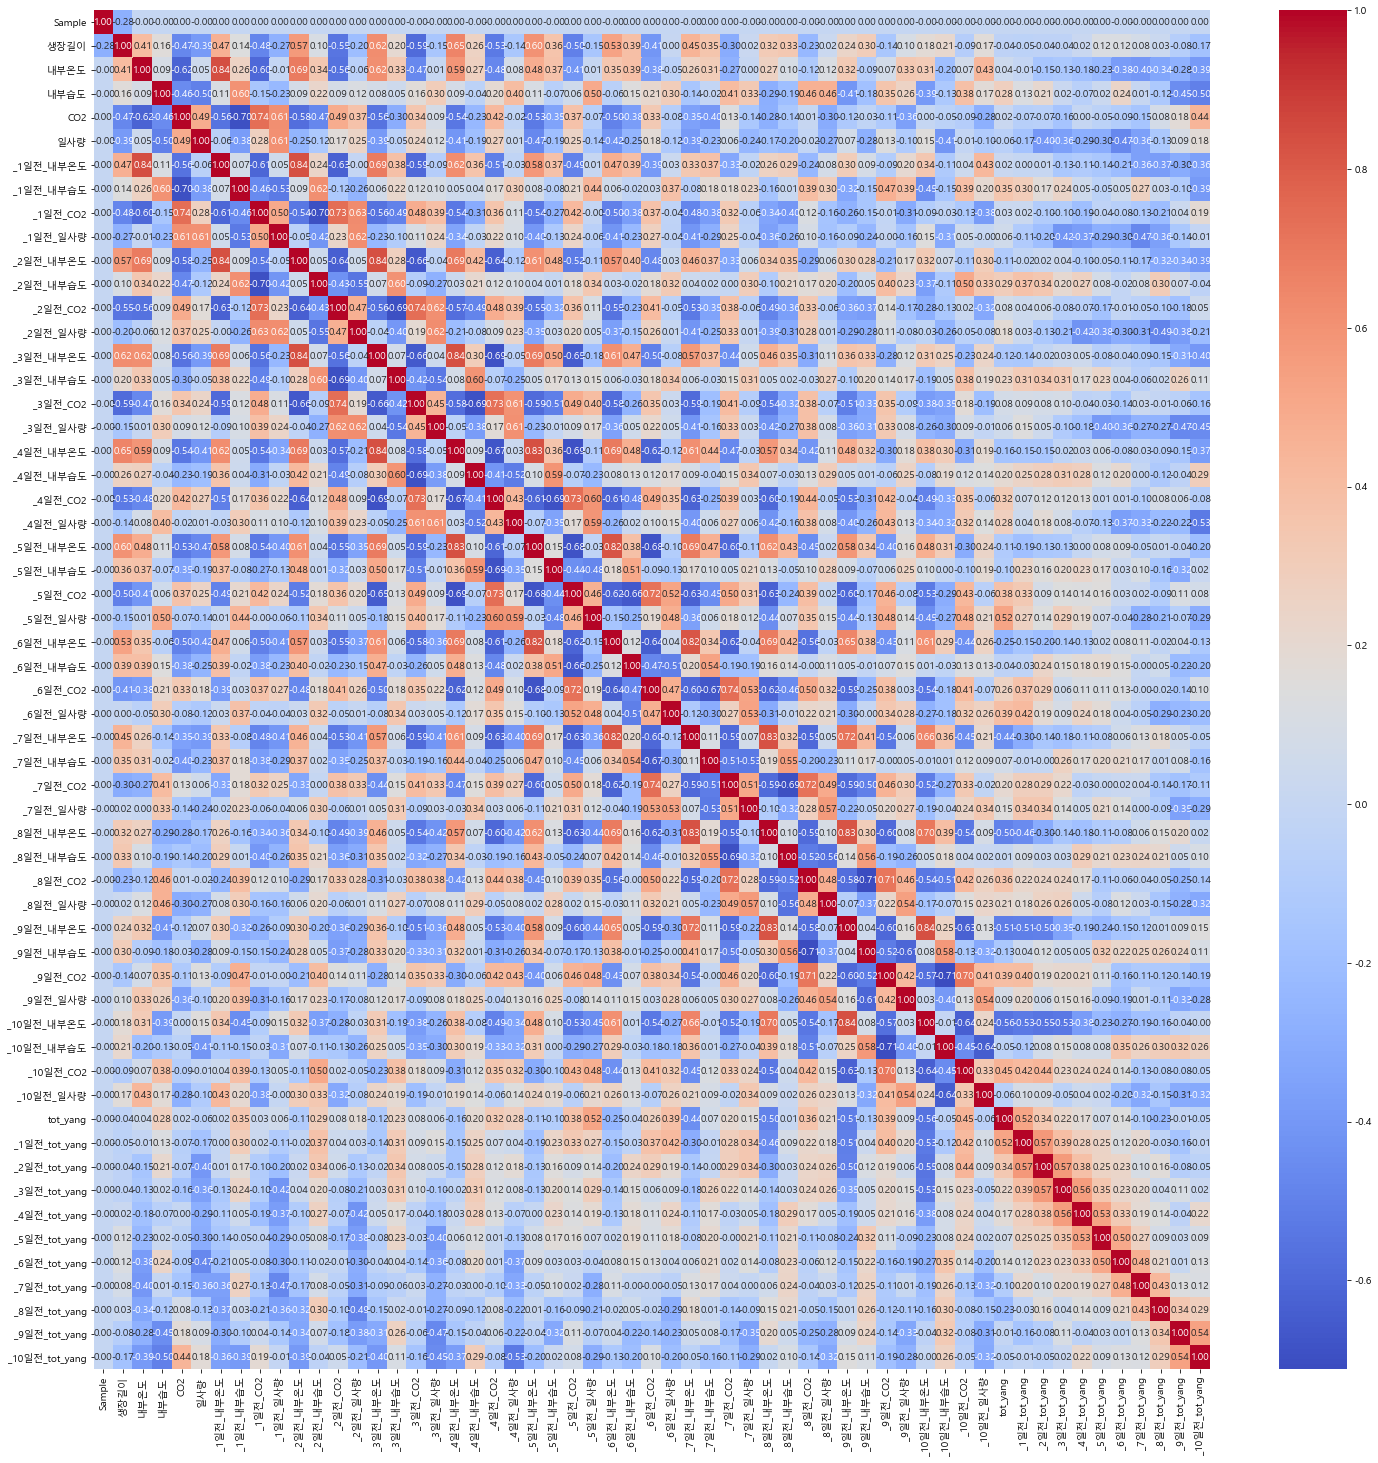

In [291]:
plt.figure(figsize=(25,25))
g = sns.heatmap(dataset1.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

# XGBOOST

In [380]:
from sklearn.datasets import load_boston
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold

In [381]:
def xgb(df,Y,hydict,type=None,plot=None):
    if type=='all':
        test_size=0.3
    else:
        test_size=0.25
    xgb_model = xgboost.XGBRegressor(n_estimators=100, gamma=0,
                               colsample_bytree=1, max_depth=7)

    parameters = hydict
    xgb_regressor = GridSearchCV(xgb_model,parameters,scoring='neg_mean_squared_error',cv=10)

    x_train=df.iloc[:,[2]+list(range(4,len(df.columns)))]
    y_train=df[Y]
    xgb_regressor.fit(x_train,y_train)
    print(xgb_regressor.best_params_)
    
    eta=xgb_regressor.best_params_['eta']
    learning_rate=xgb_regressor.best_params_['learning_rate']
    subsample = xgb_regressor.best_params_['subsample']
    
    # Kfold
    X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size)
    xgb_model = xgboost.XGBRegressor(n_estimators=100,  gamma=0,colsample_bytree=1, max_depth=7,
                                     learning_rate=learning_rate,
                                     subsample=subsample,
                                     eta=eta
                           )

    print(len(X_train), len(X_test))
    
    xgb_model.fit(X_train,y_train)
    predictions = xgb_model.predict(X_test)
    RMSE = mean_squared_error(y_test, predictions)**0.5
    print(RMSE)
    
    if plot=='ok':
        plt.figure(figsize=[10,20])
        xgboost.plot_importance(xgb_model)

        if type!='all':
            plt.figure(figsize=[15,7])
        #f, ax = plt.subplots(1, 1)
        else: 
            plt.figure(figsize=[24,12])
        sns.lineplot(x=range(len(predictions)),y=predictions,label="pred")
        sns.lineplot(x=range(len(y_test)),y=y_test,label="Test")
        plt.show()


# 환경 -20일

In [58]:
y='생장길이'
dataset['주차']=pd.to_numeric(dataset['주차'])

In [59]:
xgb(dataset,y,plot='no')

{'eta': 0.01, 'learning_rate': 0.3, 'subsample': 0.9}
846 282
3.662166196055506
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.662166196055506

In [60]:
xgb(dataset,y,plot='no')

{'eta': 0.01, 'learning_rate': 0.3, 'subsample': 0.9}
846 282
3.390397235385741
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.390397235385741

In [61]:
xgb(dataset,y,plot='no')

{'eta': 0.01, 'learning_rate': 0.3, 'subsample': 0.9}
846 282
3.5441885942209397
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.5441885942209397

In [67]:
xgb(dataset,y,plot='no')

{'eta': 0.005, 'learning_rate': 0.27, 'subsample': 0.9}
846 282
3.4705649227507345
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.4705649227507345

In [69]:
xgb(dataset,y,plot='no')

{'eta': 0.005, 'learning_rate': 0.27, 'subsample': 0.9}
846 282
3.57761915472875
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.57761915472875

In [71]:
xgb(dataset,y,plot='no')

{'eta': 0.005, 'learning_rate': 0.27, 'subsample': 0.9}
846 282
3.4532780467592397
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.4532780467592397

In [62]:
y='생장길이'
dataset_delout['주차']=pd.to_numeric(dataset_delout['주차'])

In [63]:
xgb(dataset_delout,y,plot='no')

{'eta': 0.01, 'learning_rate': 0.3, 'subsample': 0.9}
846 282
3.3883154776780504
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.3883154776780504

In [64]:
xgb(dataset_delout,y,plot='no')

{'eta': 0.01, 'learning_rate': 0.3, 'subsample': 0.9}
846 282
3.6984512865287194
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.6984512865287194

In [65]:
xgb(dataset_delout,y,plot='no')

{'eta': 0.01, 'learning_rate': 0.3, 'subsample': 0.9}
846 282
3.1968577359677983
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.1968577359677983

In [68]:
xgb(dataset_delout,y,plot='no')

{'eta': 0.005, 'learning_rate': 0.27, 'subsample': 0.9}
846 282
3.395087361620906
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.395087361620906

In [70]:
xgb(dataset_delout,y,plot='no')

{'eta': 0.005, 'learning_rate': 0.27, 'subsample': 0.9}
846 282
3.1956442227244075
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.1956442227244075

In [72]:
xgb(dataset_delout,y,plot='no')

{'eta': 0.005, 'learning_rate': 0.27, 'subsample': 0.9}
846 282
3.307048598544988
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


3.307048598544988

----
----
----
----
----
----
----
----

----

# 양액적용

### 환경 10  양액 10

In [404]:
y='생장길이'
dataset_delout1['주차']=pd.to_numeric(dataset_delout1['주차'])

hydict={'eta':[0.01,0.02,0.03,0.05],
     'learning_rate':[0.2,0.3,0.4,0.5],
     'subsample':[0.80,0.9,0.95]  
     }

{'eta': 0.01, 'learning_rate': 0.4, 'subsample': 0.9}
224 75
2.7663980968687305


<Figure size 720x1440 with 0 Axes>

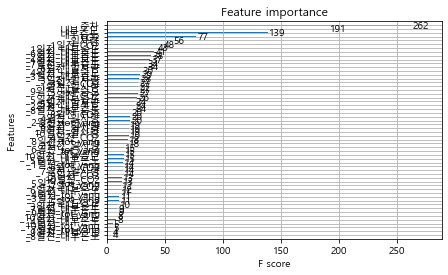

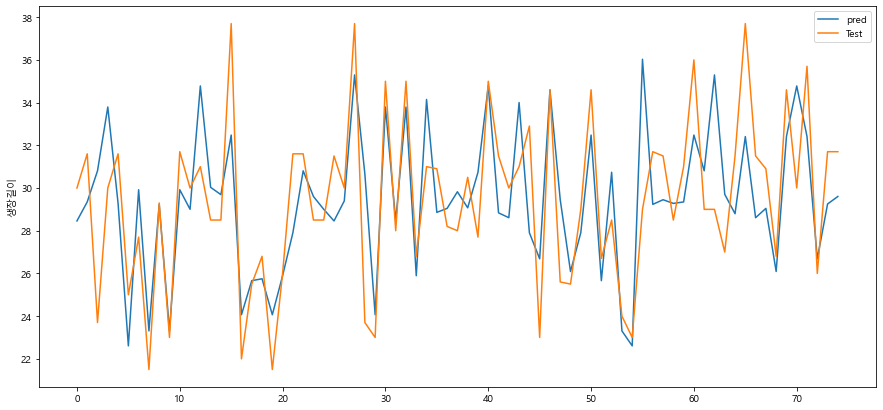

In [405]:
xgb(dataset_delout1,y,hydict,plot='ok')

{'eta': 0.01, 'learning_rate': 0.4, 'subsample': 0.9}
224 75
2.813196237657741


<Figure size 720x1440 with 0 Axes>

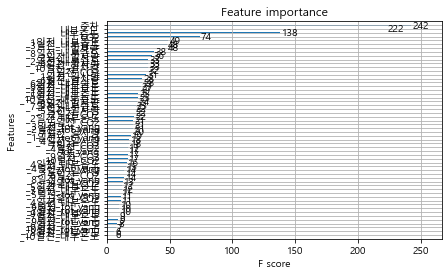

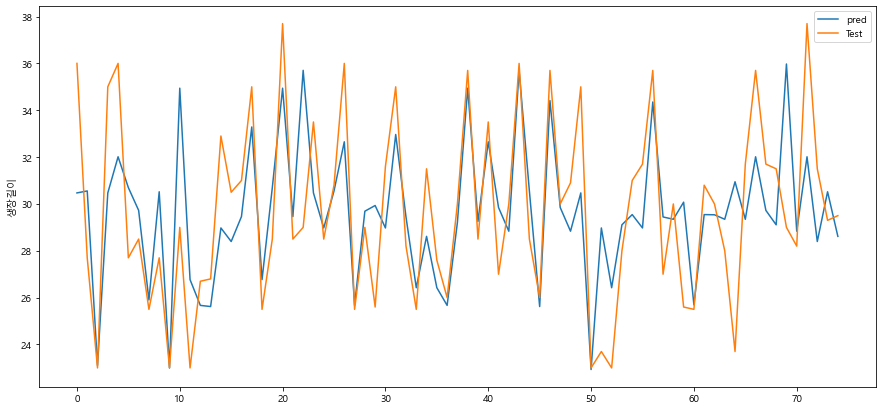

In [384]:
xgb(dataset_delout1,y,hydict,plot='ok')

{'eta': 0.01, 'learning_rate': 0.4, 'subsample': 0.9}
224 75
2.2366980797563656


<Figure size 720x1440 with 0 Axes>

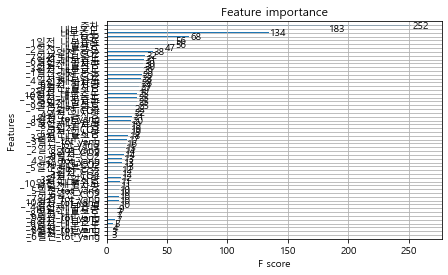

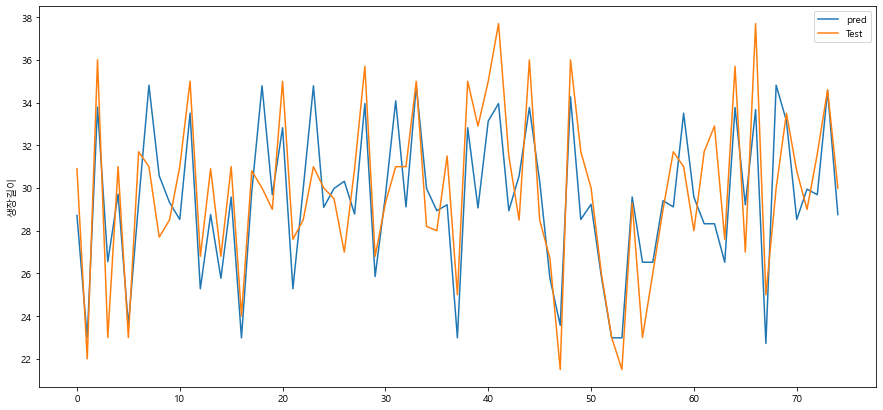

In [406]:
xgb(dataset_delout1,y,hydict,plot='ok')

{'eta': 0.01, 'learning_rate': 0.4, 'subsample': 0.9}
224 75
2.239828405733605


<Figure size 720x1440 with 0 Axes>

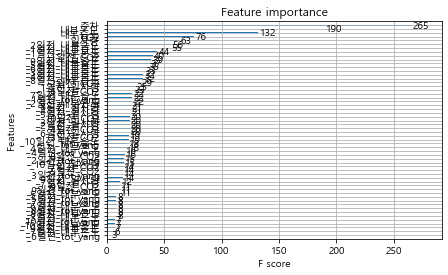

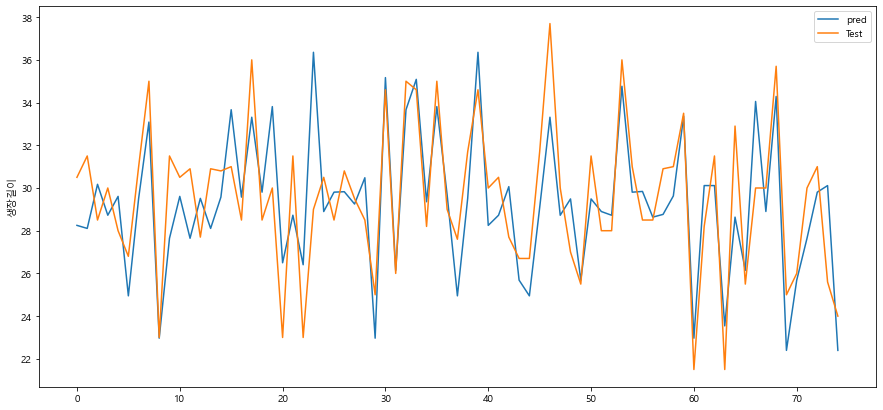

In [407]:
xgb(dataset_delout1,y,hydict,plot='ok')

In [409]:
hydict={'eta':[0.008,0.01,0.012],
     'learning_rate':[0.35,0.4,0.45],
     'subsample':[0.85,0.9,0.92]  
     }

{'eta': 0.008, 'learning_rate': 0.45, 'subsample': 0.9}
224 75
2.5645362701771597


<Figure size 720x1440 with 0 Axes>

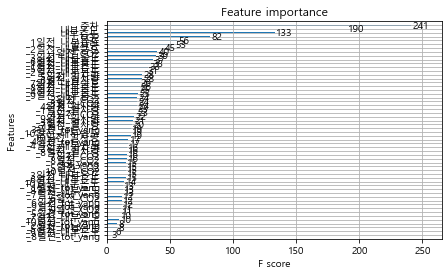

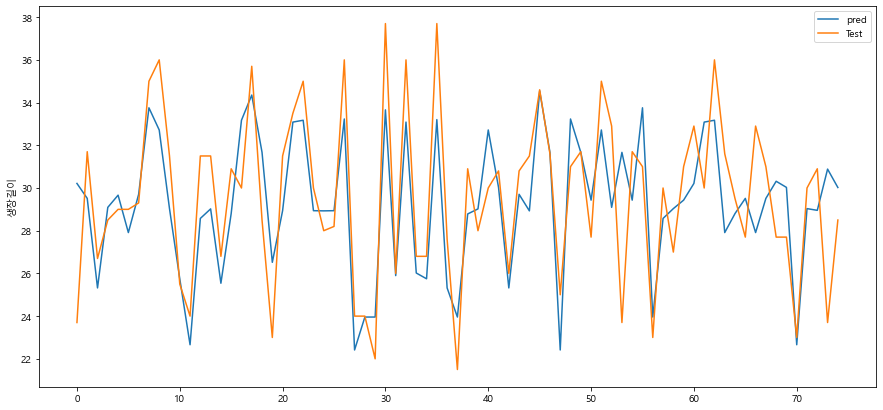

In [410]:
xgb(dataset_delout1,y,hydict,plot='ok')

{'eta': 0.008, 'learning_rate': 0.45, 'subsample': 0.9}
224 75
2.421432631931299


<Figure size 720x1440 with 0 Axes>

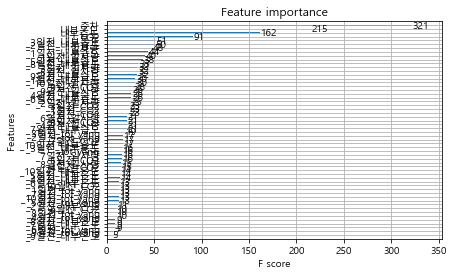

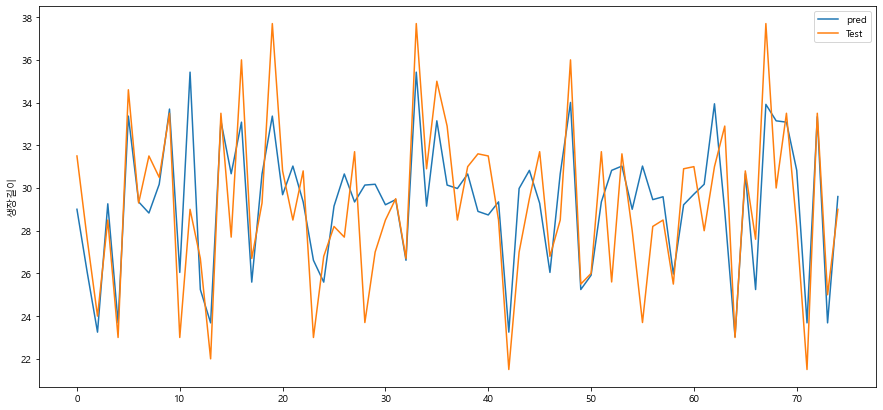

In [411]:
xgb(dataset_delout1,y,hydict,plot='ok')

{'eta': 0.008, 'learning_rate': 0.45, 'subsample': 0.9}
224 75
2.169730312336807


<Figure size 720x1440 with 0 Axes>

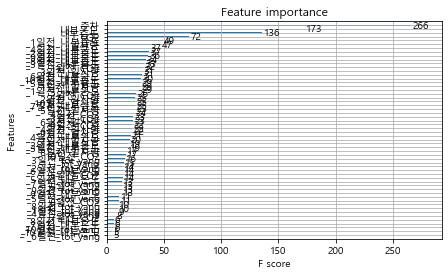

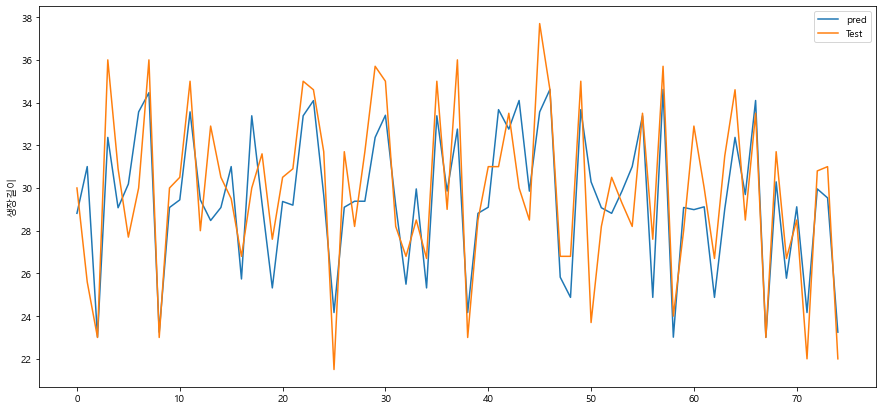

In [412]:
xgb(dataset_delout1,y,hydict,plot='ok')

In [413]:
total_model_set=pd.concat([dataset_delout1,dataset_delout2])

In [414]:
y='생장길이'
total_model_set['주차']=pd.to_numeric(total_model_set['주차'])

hydict={'eta':[0.01,0.02,0.03,0.05],
     'learning_rate':[0.2,0.3,0.4,0.5],
     'subsample':[0.80,0.9,0.95]  
     }

{'eta': 0.01, 'learning_rate': 0.3, 'subsample': 0.8}
872 291
3.2635716982489136


<Figure size 720x1440 with 0 Axes>

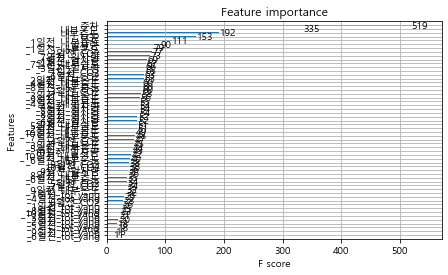

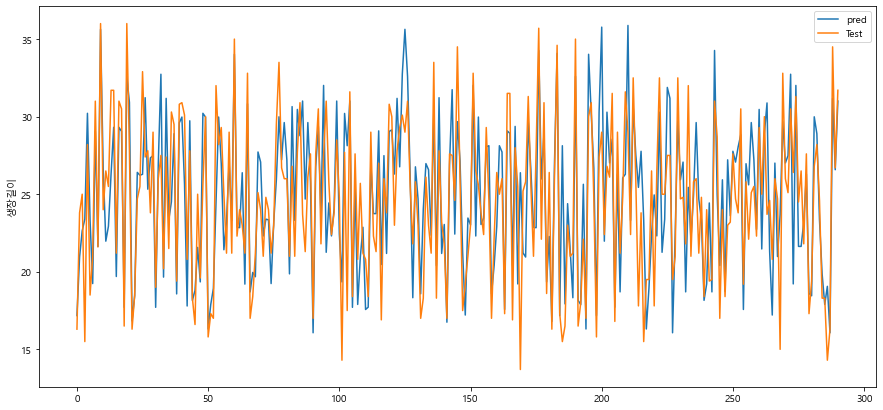

In [415]:
xgb(total_model_set,y,hydict,plot='ok')

{'eta': 0.01, 'learning_rate': 0.3, 'subsample': 0.8}
872 291
3.3572723587832503


<Figure size 720x1440 with 0 Axes>

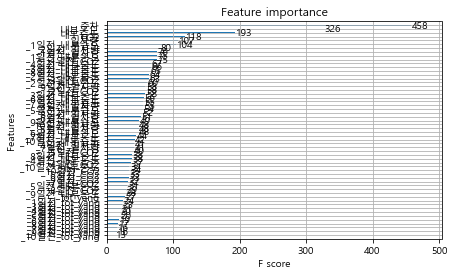

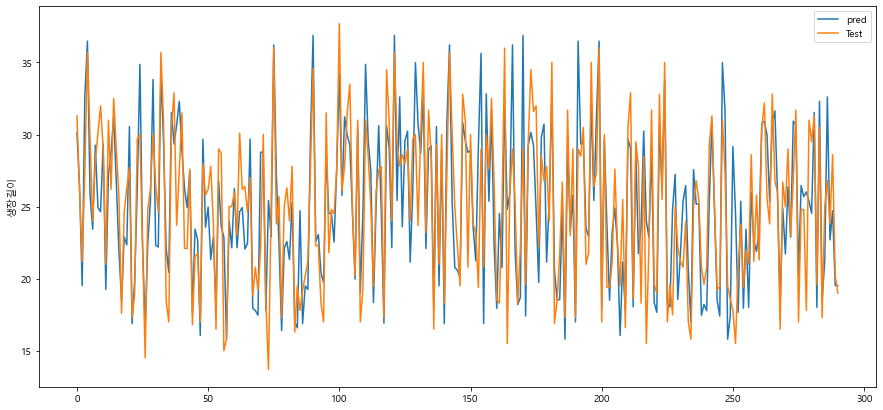

In [416]:
xgb(total_model_set,y,hydict,plot='ok')

In [ ]:
xgb(total_model_set,y,hydict,plot='ok')